# CDIPS lightcurves

Access the [CDIPS](https://archive.stsci.edu/hlsp/cdips#section-65c131d0-9994-46e6-a370-af9f2e3669cc) project. The article presenting it is [here](https://iopscience-iop-org.libproxy.mit.edu/article/10.3847/1538-4365/ab4a7e)

In [49]:
from astroquery.mast import Observations
import lightkurve as lk
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from astropy.table import Table

CLUSTER = "NGC 6231"

COORDS = {"M34":(40.53083, 42.74615), "M7":(268.46325, -34.79283), "NGC 752":(29.421, 37.785), "IC 2391": (130.133, -53.033), 
          "NGC 6231":(253.53546, -41.82667), "Lambda Orionis":(83.784490, 9.934156), "NGC 3532":(166.44923, -58.7705),
          "Collinder 140":("111.113000", "-31.850000"),
          "Omega Cen": (201.69121, -47.47686), "47 Tuc": (6.022329, -72.081444), "NGC 6752": (287.71575, -59.98185)}

In [71]:
from astroquery.vizier import Vizier

def getMag(ra, dec):
    c = coordinates.SkyCoord(ra, dec, unit=('deg', 'deg'), frame='icrs')
    result = Vizier.query_region(c, radius="0.001 deg", catalog = 'tic')
    print(result)

One possible way to access the CDIPS lightcurves is to search within a certain radius of an object.

In [72]:
obs_table = Observations.query_criteria(objectname=CLUSTER, radius="0.5 deg", provenance_name="CDIPS")
print("Found " + str(len(obs_table)) + " CDIPS light curves.")
print(obs_table.columns)
print(obs_table[0]['objID'])

print(getMag(obs_table[i]['s_ra'], obs_table[i]['s_dec']))

'''if(len(obs_table) > 0):
    cdips_products = Observations.get_product_list(obs_table)
    manifest = Observations.download_products(cdips_products)''';

Found 1118 CDIPS light curves.
<TableColumns names=('dataproduct_type','calib_level','obs_collection','obs_id','target_name','s_ra','s_dec','t_min','t_max','t_exptime','wavelength_region','filters','em_min','em_max','target_classification','obs_title','t_obs_release','instrument_name','proposal_pi','proposal_id','proposal_type','project','sequence_number','provenance_name','s_region','jpegURL','dataURL','dataRights','mtFlag','srcDen','intentType','obsid','objID','objID1','distance')>
18004785038
TableList with 2 tables:
	'0:I/197A/tic' with 10 column(s) and 1 row(s) 
	'1:IV/38/tic' with 23 column(s) and 2 row(s) 
None


<TableColumns names=('Local Path','Status','Message','URL')>
ColDefs(
    name = 'BGE'; format = 'D'; unit = 'ADU'
    name = 'BGV'; format = 'D'; unit = 'ADU'
    name = 'FDV'; format = 'D'; unit = 'unitless'
    name = 'FKV'; format = 'D'; unit = 'unitless'
    name = 'FSV'; format = 'D'; unit = 'unitless'
    name = 'IFE1'; format = 'D'; unit = 'ADU'
    name = 'IFE2'; format = 'D'; unit = 'ADU'
    name = 'IFE3'; format = 'D'; unit = 'ADU'
    name = 'IFL1'; format = 'D'; unit = 'ADU'
    name = 'IFL2'; format = 'D'; unit = 'ADU'
    name = 'IFL3'; format = 'D'; unit = 'ADU'
    name = 'IRE1'; format = 'D'; unit = 'mag'
    name = 'IRE2'; format = 'D'; unit = 'mag'
    name = 'IRE3'; format = 'D'; unit = 'mag'
    name = 'IRM1'; format = 'D'; unit = 'mag'
    name = 'IRM2'; format = 'D'; unit = 'mag'
    name = 'IRM3'; format = 'D'; unit = 'mag'
    name = 'IRQ1'; format = '1A'; unit = 'unitless'
    name = 'IRQ2'; format = '1A'; unit = 'unitless'
    name = 'IRQ3'; format = '1A'; 

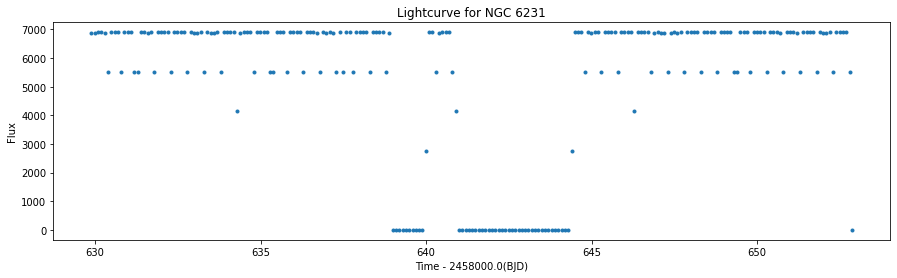

In [44]:
fig, ax = plt.subplots(ncols=1, figsize=(15, 4))

# Get the time range
NUM_MANIFESTS = 100#00


hdu = fits.open(manifest[0]['Local Path'])
minTime = min(hdu[1].data['TMID_BJD'])
maxTime = max(hdu[1].data['TMID_BJD'])
print(manifest[0].columns)
print(hdu[1].columns)

for i in range(min(len(manifest), NUM_MANIFESTS)):
    try:
        hdu = fits.open(manifest[i]['Local Path'])
        minTime = max(min(hdu[1].data['TMID_BJD']), minTime)
        maxTime = min(max(hdu[1].data['TMID_BJD']), maxTime)
    except:
        pass
    
if len(manifest) < NUM_MANIFESTS:
    print("Counting all the stars:")
else:
    print("Counting {0} / {1} stars:".format(NUM_MANIFESTS, len(manifest)))

BIN_WIDTH = 0.1

# Set up the bins
times = []
counter = minTime
timeOrigin = (minTime // 1000) * 1000
while counter < maxTime:
    times.append(counter - timeOrigin)
    counter+= BIN_WIDTH
times.append(maxTime - timeOrigin)

fluxes = [0] * len(times)

# Add all the light curves
for i in range(min(len(manifest), NUM_MANIFESTS)):
    for j in range(len(hdu[1].data['TMID_BJD'])):
        timeIndex = int((hdu[1].data['TMID_BJD'][j] - minTime) / BIN_WIDTH)
        fluxes[timeIndex] += hdu[1].data['PCA1'][j]

ax.scatter(times, fluxes, marker='.')
ax.set_xlabel('Time - ' + str(timeOrigin) + '(BJD)');
ax.set_ylabel('Flux');
ax.set_title("Lightcurve for {0}".format(CLUSTER));

## Search directly for stars.

Another way is to name an object directly. Choose either this method or the above.

In [11]:
# Search for CDIPS light curves directly based on TIC ID.
ticid = CLUSTER#'220314428'
obs_table = Observations.query_criteria(target_name=ticid, provenance_name="CDIPS")
print("Found " + str(len(obs_table)) + " CDIPS light curves.")
if(len(obs_table) > 0):
    # Get list of available products for this Observation.
    cdips_products = Observations.get_product_list(obs_table)
    # Download the products for this Observation.
    manifest = Observations.download_products(cdips_products)

Found 0 CDIPS light curves.


Finally, we can draw the downloaded lightcurves.

OSError: Empty or corrupt FITS file

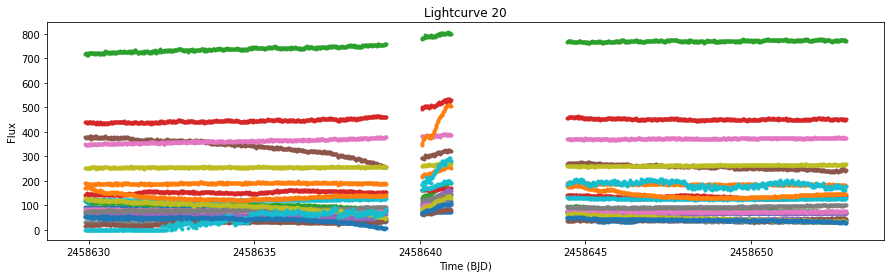

In [12]:
fig, ax = plt.subplots(ncols=1, figsize=(15, 4))

#-- Open the spectrum and plot
for i in range(len(manifest)):
    hdu = fits.open(manifest[i][0])
    #print(hdu[1].columns)
    ax.scatter(hdu[1].data['TMID_BJD'].ravel(), hdu[1].data['IFL1'].ravel(), marker='.')
    ax.ticklabel_format(useOffset=False, style='plain');
    ax.set_xlabel('Time (BJD)');
    ax.set_ylabel('Flux');
    ax.set_title("Lightcurve " + str(i))